In [42]:
%matplotlib inline

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [44]:
df = pd.read_csv('assets/housing.csv')

## Overview at data structure

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [46]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [47]:
# df['ocean_proximity'] = df['ocean_proximity'].map({'NEAR BAY': 0, '<1H OCEAN': 1, 'INLAND': 2, 'NEAR OCEAN': 3, 'ISLAND': 4})

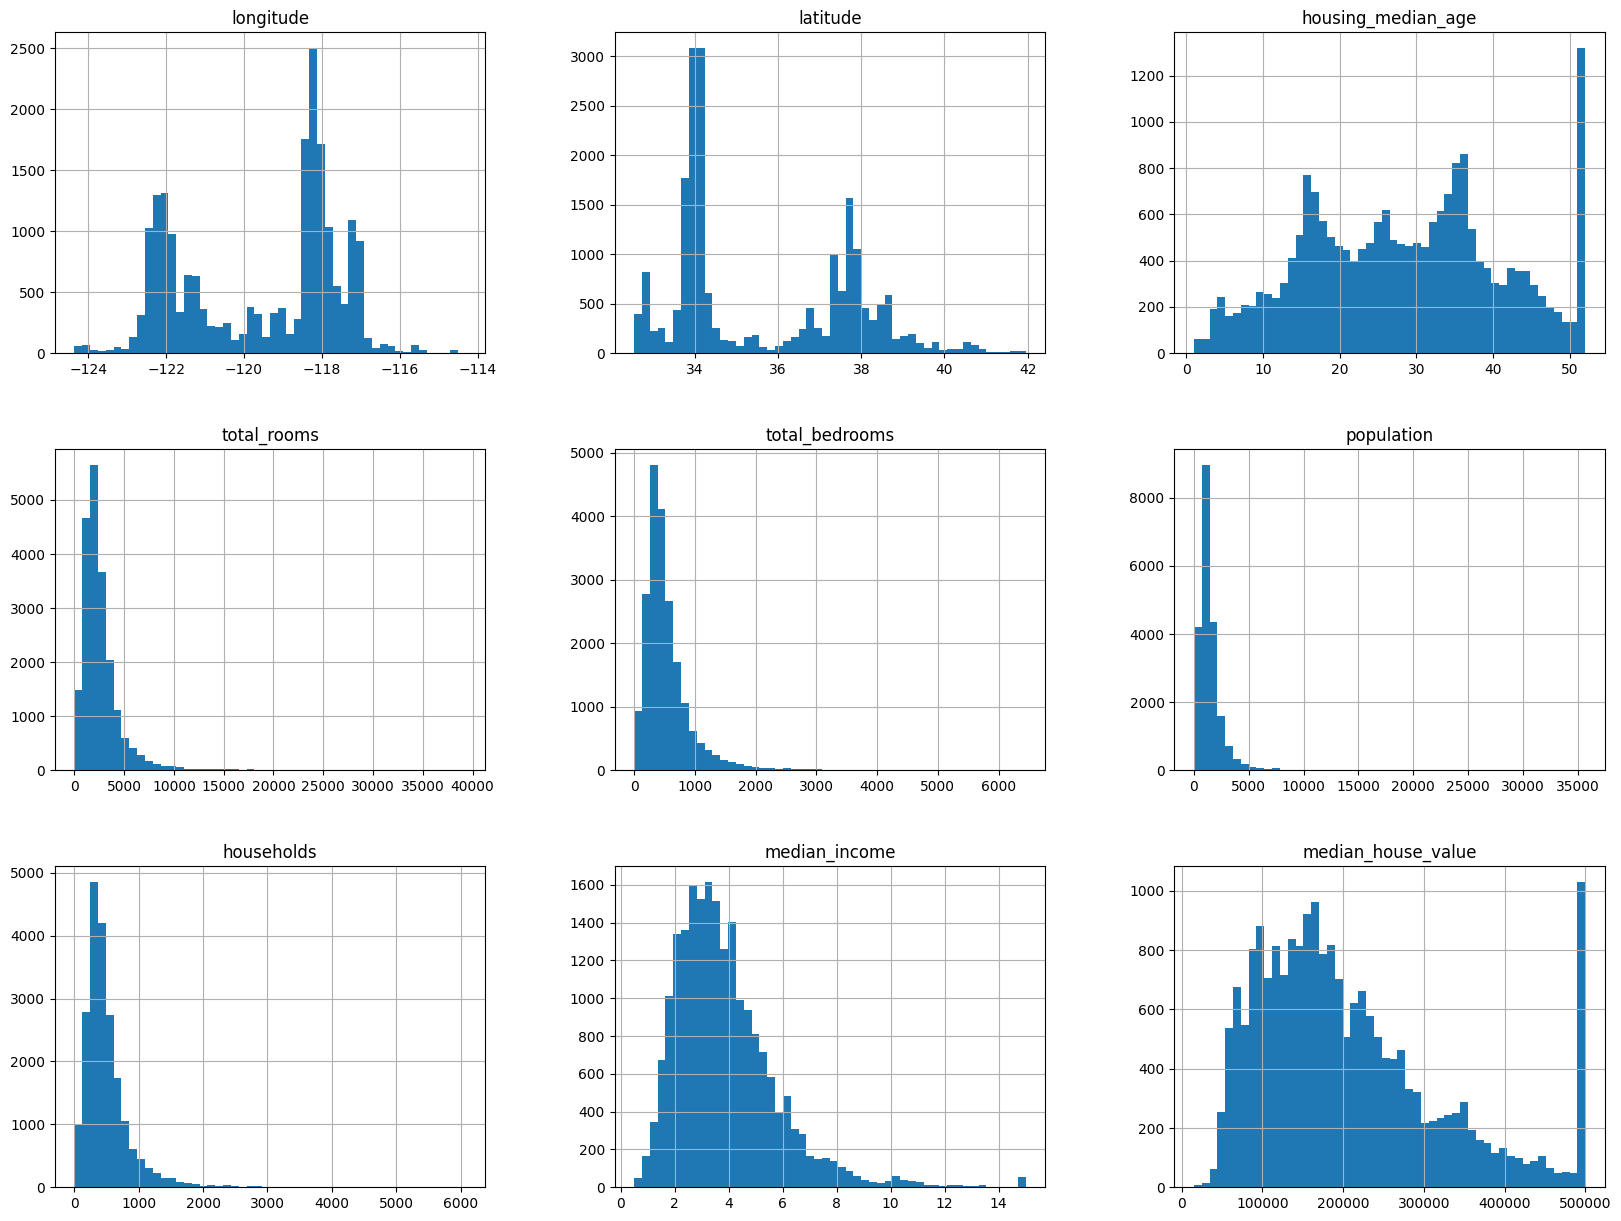

In [48]:
hist_axes = df.hist(bins=50, figsize=(20,15))  # Sem o output

Text(0.5, 1.0, 'Distribution of Ocean Proximity')

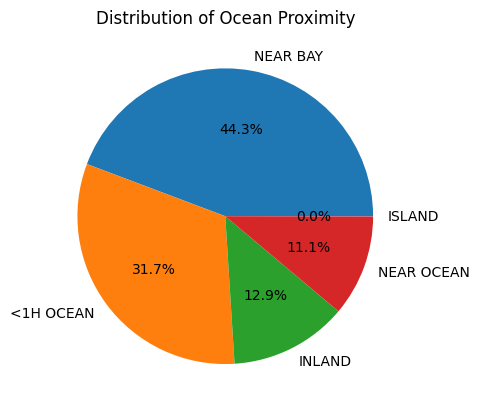

In [49]:
plt.pie(df['ocean_proximity'].value_counts(), labels=df['ocean_proximity'].unique(), autopct='%1.1f%%')
plt.title('Distribution of Ocean Proximity')

## Split test train

In [50]:
from sklearn.model_selection import StratifiedShuffleSplit

In [51]:
df['income_cat'] = pd.cut(  # Discretização de valor contínuo
    df['median_income'],
    bins=[0., 1.5, 3.0, 4.5, 6., np.inf],  # Intervalos
    labels=[1, 2, 3, 4, 5]
)

<Axes: >

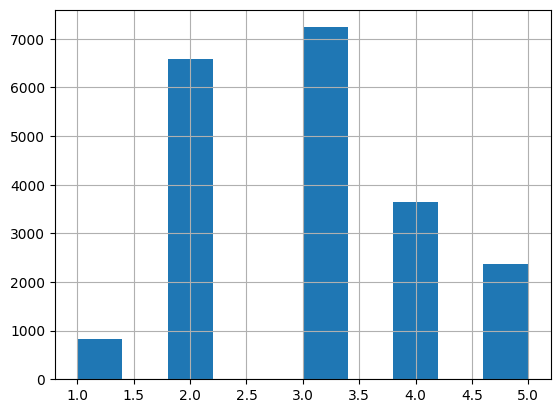

In [52]:
df['income_cat'].hist()

In [53]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)  # Ver depois
for train_index, test_index in split.split(df, df['income_cat']):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

In [54]:
# Checar proporções
prop = pd.DataFrame()

prop['Train'] = strat_train_set['income_cat'].value_counts() / len(strat_train_set)
prop['Original'] = df['income_cat'].value_counts() / len(df)

prop['Error'] = prop['Train'] - prop['Original']

prop

,Train,Original,Error
income_cat,,,
3,0.350594,0.350581,0.000012
2,0.318859,0.318847,0.000012
4,0.176296,0.176308,-0.000012
5,0.114462,0.114438,0.000024
1,0.039789,0.039826,-0.000036


## Deep exploration

In [55]:
train_df = strat_train_set.copy()

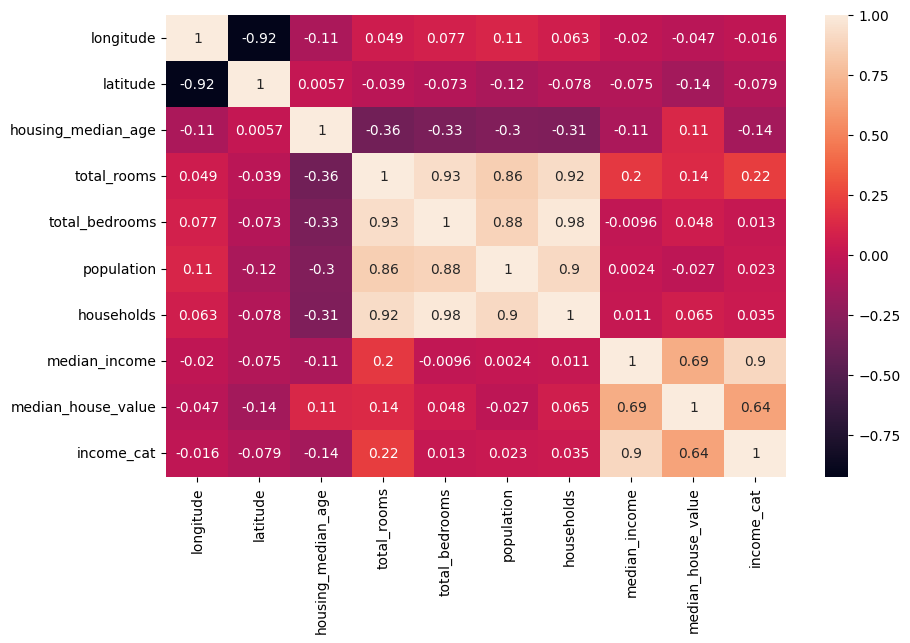

In [56]:
plt.figure(figsize=(10, 6))
sns.heatmap(train_df.drop('ocean_proximity', axis=1).corr(), annot=True)
plt.show()

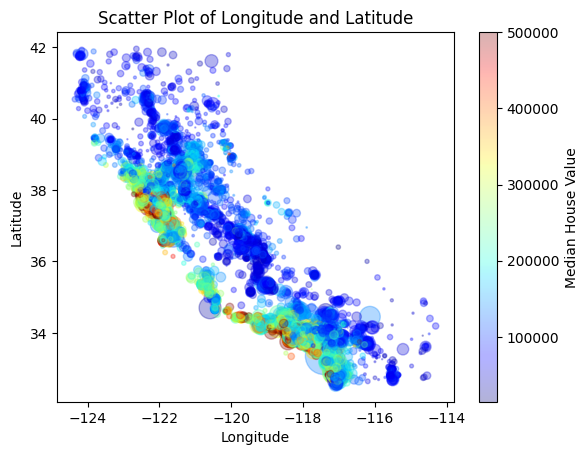

In [57]:
plt.scatter(train_df['longitude'], train_df['latitude'], alpha=0.3, c=train_df['median_house_value'], cmap='jet',s=train_df['population']/50)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Scatter Plot of Longitude and Latitude')
plt.colorbar(label='Median House Value')
plt.show()

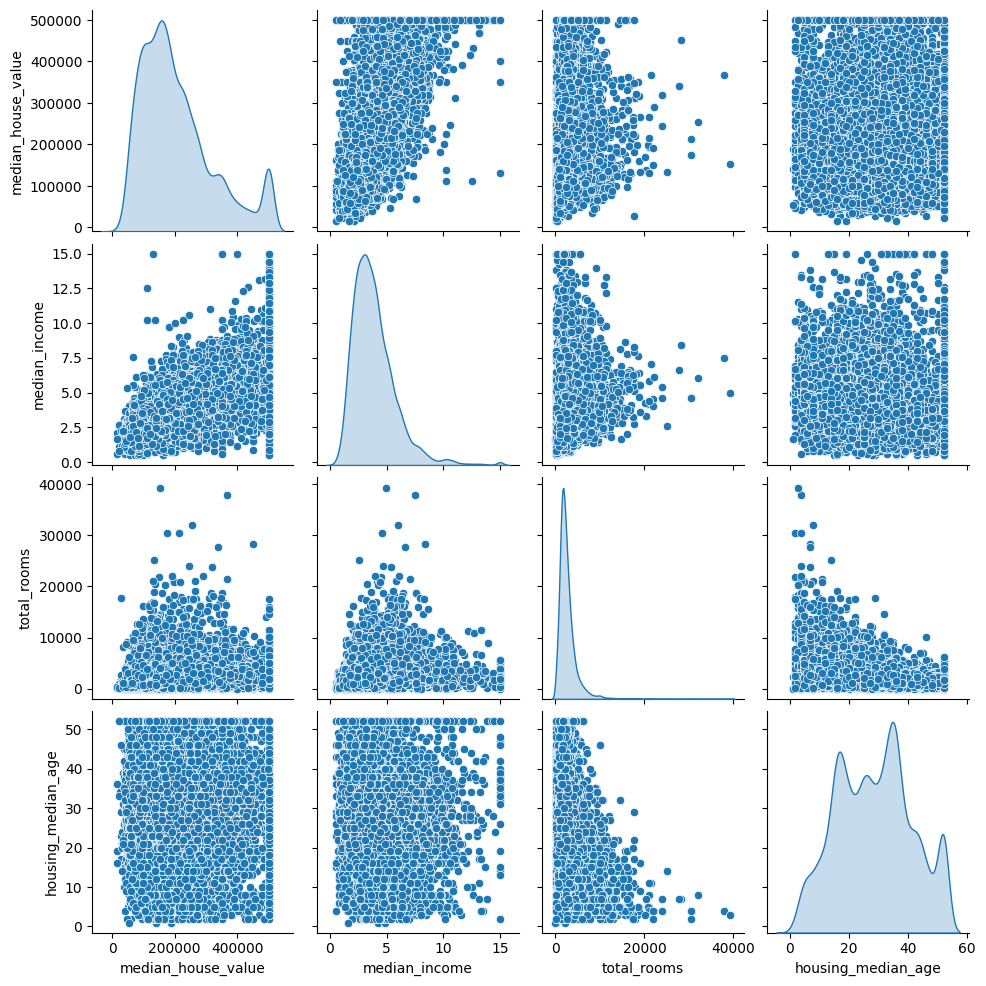

In [58]:
# Análisar principais correlações com a variável alvo

attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
sns.pairplot(train_df[attributes], diag_kind='kde')

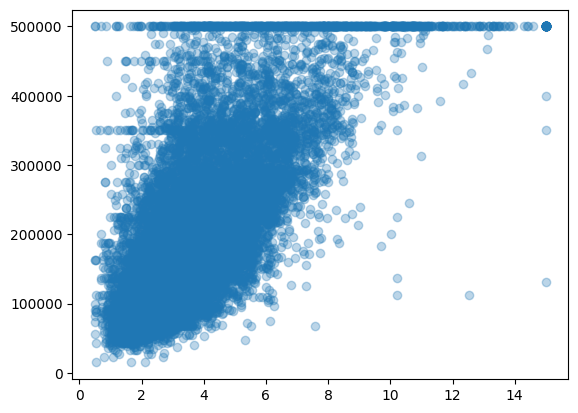

In [59]:
# Avaliar alguns gráficos mais de perto, com configurações

plt.scatter(train_df['median_income'], train_df['median_house_value'], alpha=0.3)

## Feature combining

In [60]:
# Criar features que correlacionem melhor com o alvo

train_df['rooms_per_household'] = train_df['total_rooms'] / train_df['households']
train_df['bedrooms_per_room'] = train_df['total_bedrooms'] / train_df['total_rooms']
train_df['population_per_household'] = train_df['population'] / train_df['households']

In [61]:
train_df.drop('ocean_proximity', axis=1).corr()['median_house_value'].sort_values(ascending=False)  # Sem precisar do gráfico completo

median_house_value          1.000000
median_income               0.687151
income_cat                  0.642256
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

# Pre-processing

## Clearing data

In [62]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')

df_num = train_df.drop(['ocean_proximity', 'income_cat'], axis=1)
imputer.fit(df_num)

SimpleImputer(strategy='median')

In [63]:
X = imputer.transform(df_num)
df_tr = pd.DataFrame(X, columns=df_num.columns, index=df_num.index)

In [64]:
df_tr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 12655 to 19773
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   longitude                 16512 non-null  float64
 1   latitude                  16512 non-null  float64
 2   housing_median_age        16512 non-null  float64
 3   total_rooms               16512 non-null  float64
 4   total_bedrooms            16512 non-null  float64
 5   population                16512 non-null  float64
 6   households                16512 non-null  float64
 7   median_income             16512 non-null  float64
 8   median_house_value        16512 non-null  float64
 9   rooms_per_household       16512 non-null  float64
 10  bedrooms_per_room         16512 non-null  float64
 11  population_per_household  16512 non-null  float64
dtypes: float64(12)
memory usage: 1.6 MB


## Handling category data

In [65]:
"""from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
df_cat = train_df[['ocean_proximity']]
df_cat_encoded = ordinal_encoder.fit_transform(df_cat)"""

"from sklearn.preprocessing import OrdinalEncoder\n\nordinal_encoder = OrdinalEncoder()\ndf_cat = train_df[['ocean_proximity']]\ndf_cat_encoded = ordinal_encoder.fit_transform(df_cat)"

In [66]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
df_cat = train_df[['ocean_proximity']]
df_cat_1hot = cat_encoder.fit_transform(df_cat)

In [67]:
df = df.join(pd.get_dummies(df.ocean_proximity)).drop(['ocean_proximity'], axis=1)  # Jeito chibas

<Axes: >

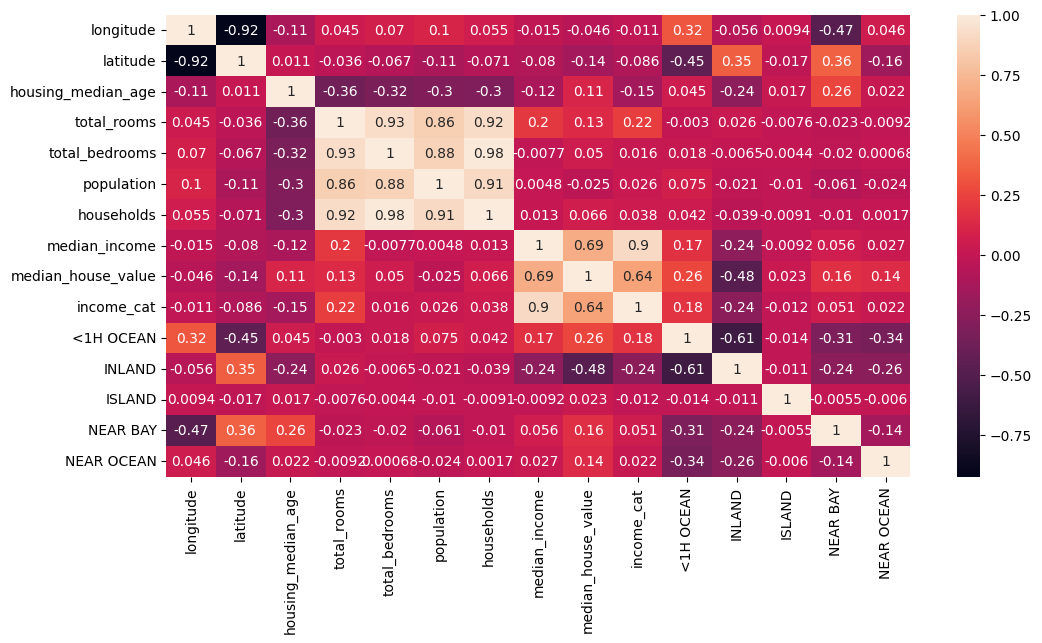

In [73]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.corr(), annot=True )